In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

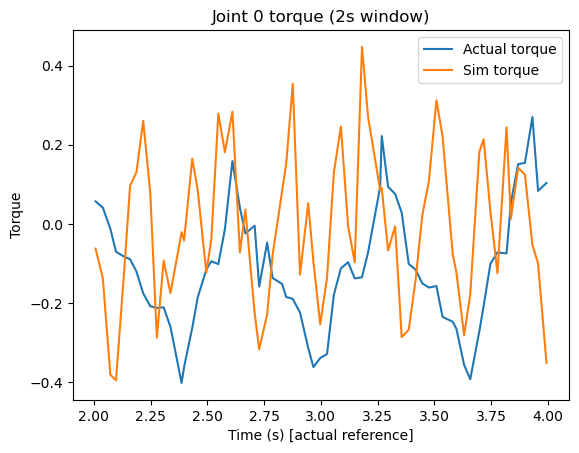

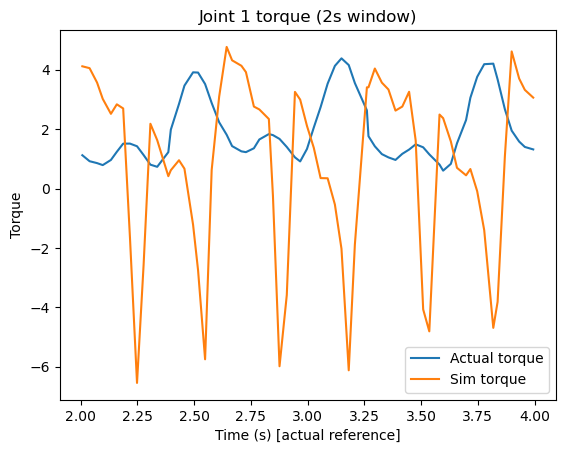

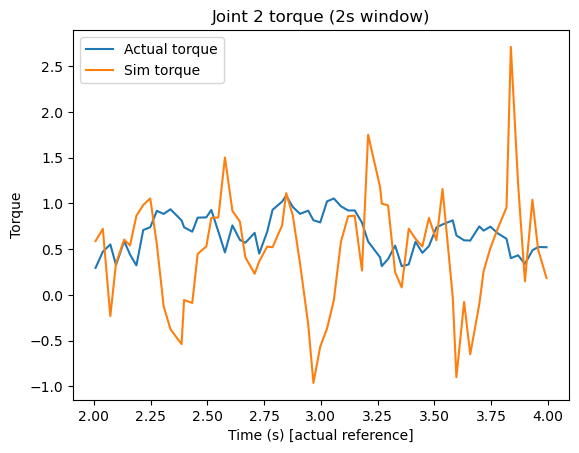

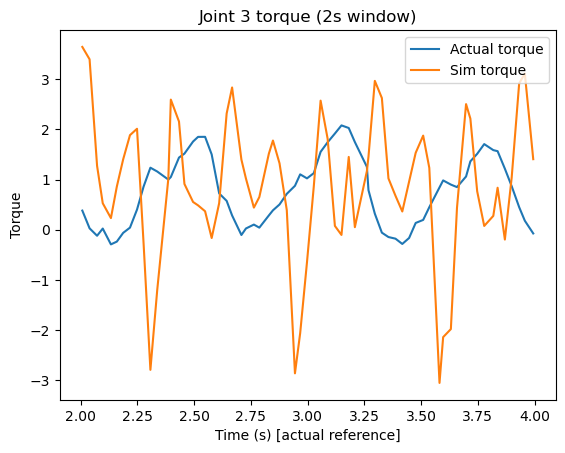

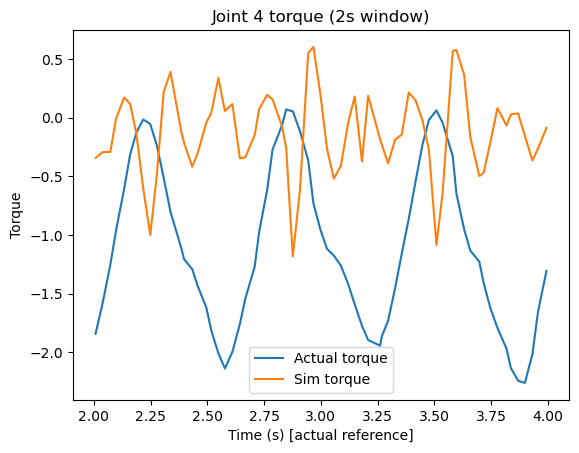

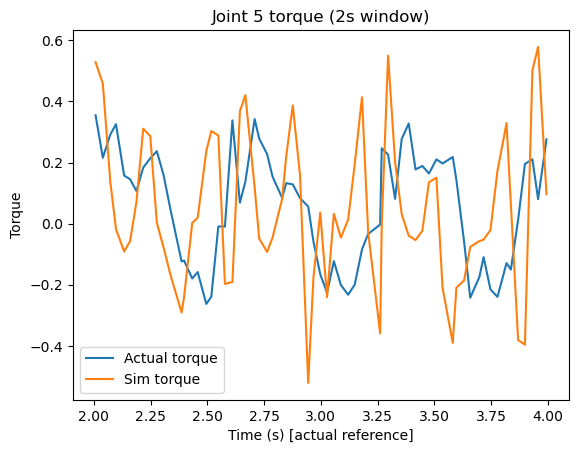

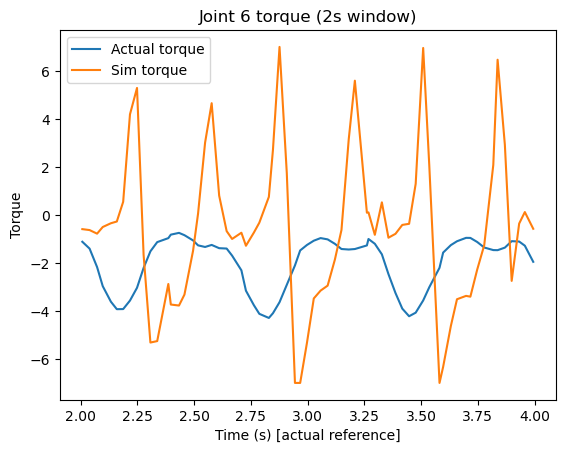

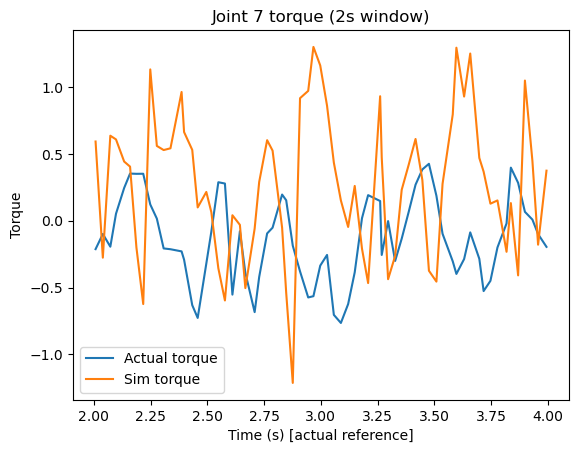

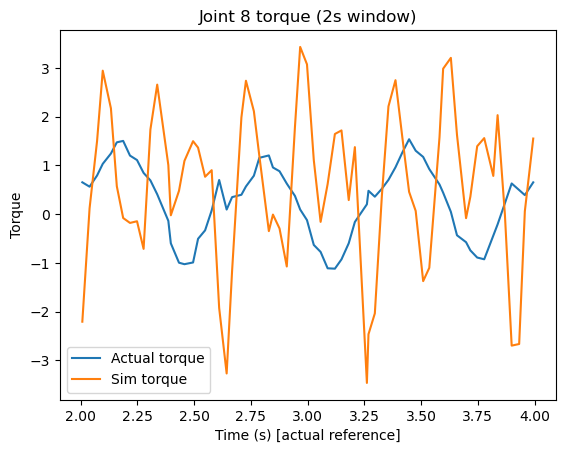

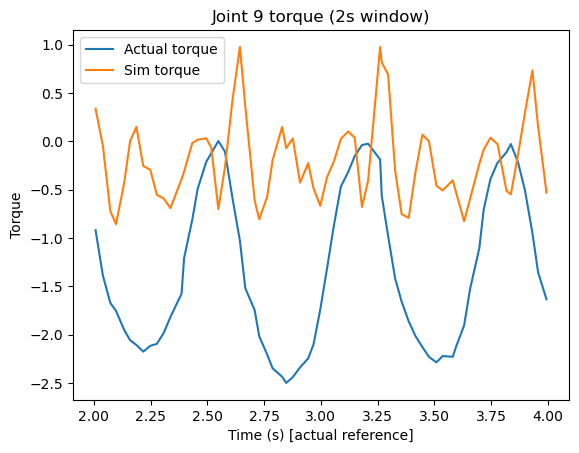

In [23]:
act_cols = [
    "time_str",    # e.g. "2025/04/01/ 21:40:20::816"
    "tau_0","tau_1","tau_2","tau_3","tau_4",
    "tau_5","tau_6","tau_7","tau_8","tau_9"
]
sim_cols = [
    "sim_time",    # e.g. 0.001
    "tau_0","tau_1","tau_2","tau_3","tau_4",
    "tau_5","tau_6","tau_7","tau_8","tau_9"
]
act_df = pd.read_csv("act_tor.csv", header=0, names=act_cols)
def parse_act_timestamp(dt_str):
    return datetime.datetime.strptime(dt_str, "%Y/%m/%d/ %H:%M:%S::%f")

act_df["datetime"] = act_df["time_str"].apply(parse_act_timestamp)
start_time = act_df["datetime"].iloc[0]
act_df["act_time"] = (act_df["datetime"] - start_time).dt.total_seconds()
act_df.drop(columns=["time_str","datetime"], inplace=True)
act_df.sort_values("act_time", inplace=True)

sim_df = pd.read_csv("sim_tor.csv", header=0, names=sim_cols)
sim_df.rename(columns={"sim_time": "sim_time_sec"}, inplace=True)
sim_df.sort_values("sim_time_sec", inplace=True)

actual_window_start = 2.0
actual_window_length = 2.0
act_window = act_df[
    (act_df["act_time"] >= actual_window_start) 
    & (act_df["act_time"] <= actual_window_start + actual_window_length)
].copy()

sim_window_start = 2.0
sim_window_length = 2.0
sim_window = sim_df[
    (sim_df["sim_time_sec"] >= sim_window_start) 
    & (sim_df["sim_time_sec"] <= sim_window_start + sim_window_length)
].copy()

time_shift = 0.03  # try e.g. 0.02 or -0.03
sim_window["sim_time_sec"] += time_shift

aligned_df = pd.merge_asof(
    act_window.sort_values("act_time"),
    sim_window.sort_values("sim_time_sec"),
    left_on="act_time",
    right_on="sim_time_sec",
    direction="nearest",
    suffixes=("_act","_sim")
)

for i in range(10):
    plt.figure()
    plt.plot(aligned_df["act_time"], aligned_df[f"tau_{i}_act"], label="Actual torque")
    plt.plot(aligned_df["act_time"], aligned_df[f"tau_{i}_sim"], label="Sim torque")
    plt.title(f"Joint {i} torque (2s window)")
    plt.xlabel("Time (s) [actual reference]")
    plt.ylabel("Torque")
    plt.legend()
    plt.show()